In [1]:
import numpy as np
import pandas as pd
import pymysql
import json
from helpers import *
import ast
from datetime import datetime, timedelta, date
import bisect
from matplotlib import pyplot as plt

In [2]:
cursor = get_cursor()

In [4]:
'''

Loops through 2024 dates and queries all of the orderbook delta messages (for all NDX and SPX range markets on Kalshi) occuring on that date that 
I have stored in a MySQL DB. Loops through each orderbook delta on a given day and updates a local state of 
the limit orderbook for that market. Appends to a dataframe, the best bid, ask, orderbook imbalance, and midprice after each delta is processed.

'''


bids = {}
asks = {}
data_dict = {'best_bid': [], 'best_ask': [], 'obi_l1': [], 'obi_total': [], 'ticker': [], 'timestamp': []}
date_ = date(2024, 1, 2)

while date_ <= date.today():
    
    #find number of commands
    cursor.execute('select count(distinct(command_id)) from ob_snapshot where processed_ts like \'%{}%\''.format(date_.isoformat()))
    rows = cursor.fetchall()
    num_cmd_ids = None
    
    if rows is not None and len(rows) > 0:
        num_cmd_ids = rows[0][0]
    if num_cmd_ids is None:
        continue
    
    for cmd_id in range(1,num_cmd_ids+1):
        cursor.execute('select * from ob_snapshot where command_id = {} and processed_ts like \'%{}%\' order by processed_ts asc'.format(cmd_id, date_.isoformat()))
        snapshot_rows = cursor.fetchall()
        cursor.execute('select max(seq_num) from ob_snapshot where command_id = {} and processed_ts like \'%{}%\''.format(cmd_id, date_.isoformat()))
        max_seqnum = cursor.fetchall()[0][0]
        
        if max_seqnum != len(snapshot_rows):
            continue
            
        for row in snapshot_rows:
            t = row[2]
            try:
                bids_dict = ast.literal_eval(row[3])
                asks_dict = ast.literal_eval(row[4])
            except:
                continue
            bids_list = []
            asks_list = []
            for p, q in bids_dict.items():
                bids_list.append([p, q])
            for p, q in asks_dict.items():
                asks_list.append([p, q])
            
            bids_list.sort(key = lambda x:x[0])
            asks_list.sort(key = lambda x:x[0])
            
            bids[t] = bids_list[:]
            asks[t] = asks_list[:]
            
            data_dict['best_bid'].append(get_best_bid(bids[t]))
            data_dict['best_ask'].append(get_best_ask(asks[t]))
            data_dict['obi_l1'].append(calc_orderboook_imb(bids[t], asks[t], 1))
            data_dict['obi_total'].append(calc_orderboook_imb(bids[t], asks[t], 4))
            data_dict['ticker'].append(t)
            data_dict['timestamp'].append(datetime.strptime(row[5], '%Y-%m-%dT%H:%M:%S.%fZ'))
        
        cursor.execute('select * from ob_delta where command_id = {} and processed_ts like \'%{}%\' order by processed_ts asc'.format(cmd_id, date_.isoformat()))
        delta_rows = cursor.fetchall()
        for row in delta_rows:
            t = row[2]
            price = row[3]
            delta = row[4]
            side = row[5]
            
            if side == 'yes':
                #bid
                if t in bids:
                    update_bids(bids[t], price, delta)
                else:
                    continue
            else:
                #ask
                if t in asks:
                    update_asks(asks[t], price, delta)
                else:
                    continue
            
            
            data_dict['best_bid'].append(get_best_bid(bids[t]))
            data_dict['best_ask'].append(get_best_ask(asks[t]))
            data_dict['obi_l1'].append(calc_orderboook_imb(bids[t], asks[t], 1))
            data_dict['obi_total'].append(calc_orderboook_imb(bids[t], asks[t], 4))
            data_dict['ticker'].append(t)
            data_dict['timestamp'].append(datetime.strptime(row[6], '%Y-%m-%dT%H:%M:%S.%fZ'))
    
    date_+=timedelta(days=1)      
            

data = pd.DataFrame(data_dict)

In [5]:
data['midprice'] = data.apply(lambda x: (x['best_bid'] + x['best_ask'])/2, axis = 1)

In [6]:
data[-100:]

,best_bid,best_ask,obi_l1,obi_total,ticker,timestamp,midprice
982345,25,35.0,0.000000,0.189985,INX-24FEB15-B5012,2024-02-15 20:54:34.127170,30.0
982346,25,35.0,0.000000,0.147727,INX-24FEB15-B5012,2024-02-15 20:54:34.127191,30.0
982347,25,35.0,0.000000,0.108368,INX-24FEB15-B5012,2024-02-15 20:54:34.127226,30.0
982348,25,33.0,0.000000,0.071618,INX-24FEB15-B5012,2024-02-15 20:54:34.127247,29.0
982349,25,33.0,0.000000,0.039781,INX-24FEB15-B5012,2024-02-15 20:54:35.094915,29.0
...,...,...,...,...,...,...,...
982440,22,31.0,0.000000,0.004975,INX-24FEB15-B5012,2024-02-15 20:54:40.147058,26.5
982441,22,31.0,0.000000,0.034982,INX-24FEB15-B5012,2024-02-15 20:54:40.147081,26.5
982442,68,75.0,0.142857,0.289474,INX-24FEB15-B5037,2024-02-15 20:54:40.147102,71.5
982443,68,75.0,-0.272727,0.225000,INX-24FEB15-B5037,2024-02-15 20:54:40.148672,71.5


In [7]:
data['date'] = data.apply(lambda x: date(x['timestamp'].year, x['timestamp'].month, x['timestamp'].day), axis=1)
data['hour'] = data.apply(lambda x: x['timestamp'].hour, axis=1)
data['minute'] = data.apply(lambda x: x['timestamp'].minute, axis=1)
data['seconds'] = data.apply(lambda x: x['timestamp'].second, axis=1)

In [8]:
data

,best_bid,best_ask,obi_l1,obi_total,ticker,timestamp,midprice,date,hour,minute,seconds
0,0,2.0,-1.000000,-1.000000,INXD-24JAN03-B4662,2024-01-03 20:15:48.494189,1.0,2024-01-03,20,15,48
1,11,13.0,-0.733333,-0.428927,INXD-24JAN03-B4687,2024-01-03 20:15:48.506276,12.0,2024-01-03,20,15,48
2,72,75.0,-0.739130,-0.279853,INXD-24JAN03-B4712,2024-01-03 20:15:48.513190,73.5,2024-01-03,20,15,48
3,11,12.0,-0.652174,0.251673,INXD-24JAN03-B4737,2024-01-03 20:15:48.523760,11.5,2024-01-03,20,15,48
4,0,1.0,-1.000000,-1.000000,INXD-24JAN03-B4762,2024-01-03 20:15:48.537417,0.5,2024-01-03,20,15,48
...,...,...,...,...,...,...,...,...,...,...,...
982440,22,31.0,0.000000,0.004975,INX-24FEB15-B5012,2024-02-15 20:54:40.147058,26.5,2024-02-15,20,54,40
982441,22,31.0,0.000000,0.034982,INX-24FEB15-B5012,2024-02-15 20:54:40.147081,26.5,2024-02-15,20,54,40
982442,68,75.0,0.142857,0.289474,INX-24FEB15-B5037,2024-02-15 20:54:40.147102,71.5,2024-02-15,20,54,40
982443,68,75.0,-0.272727,0.225000,INX-24FEB15-B5037,2024-02-15 20:54:40.148672,71.5,2024-02-15,20,54,40


In [26]:
data_minute_lvl = data.groupby(['ticker', 'hour', 'minute']).last()

In [14]:
data_minute_lvl

best_bid  best_ask  obi_l1  \
ticker                       hour minute                               
INX-24FEB08-B4862            20   15             0       1.0    -1.0   
                                  24             0       1.0    -1.0   
                                  25             0       1.0    -1.0   
                                  54             0       1.0    -1.0   
                                  55             0       1.0    -1.0   
...                                            ...       ...     ...   
NASDAQ100D-24JAN19-T17499.99 20   15             0       1.0    -1.0   
                                  30             0       1.0    -1.0   
                                  34             0       1.0    -1.0   
                                  54             0       1.0    -1.0   
                                  59             0       1.0    -1.0   

                                          obi_total  \
ticker                       hour minute              
INX-24FEB08-B4862            20   15           -1.0   
                                  24           -1.0   
                                  25           -1.0   
                                  54           -1.0   
                                  55           -1.0   
...                                             ...   
NASDAQ100D-24JAN19-T17499.99 20   15           -1.0   
                                  30           -1.0   
                                  34           -1.0   
                                  54           -1.0   
                                  59           -1.0   

                                                          timestamp  midprice  \
ticker                       hour minute                                        
INX-24FEB08-B4862            20   15     2024-02-08 20:15:48.373698       0.5   
                                  24     2024-02-08 20:24:31.246591       0.5   
                                  25     2024-02-08 20:25:12.225434       0.5   
                                  54     2024-02-08 20:54:41.251106       0.5   
                                  55     2024-02-08 20:55:23.268969       0.5   
...                                                             ...       ...   
NASDAQ100D-24JAN19-T17499.99 20   15     2024-01-19 20:15:48.465095       0.5   
                                  30     2024-01-19 20:30:00.603938       0.5   
                                  34     2024-01-19 20:34:27.305833       0.5   
                                  54     2024-01-19 20:54:59.486592       0.5   
                                  59     2024-01-19 20:59:58.842587       0.5   

                                                date  seconds  
ticker                       hour minute                       
INX-24FEB08-B4862            20   15      2024-02-08       48  
                                  24      2024-02-08       31  
                                  25      2024-02-08       12  
                                  54      2024-02-08       41  
                                  55      2024-02-08       23  
...                                              ...      ...  
NASDAQ100D-24JAN19-T17499.99 20   15      2024-01-19       48  
                                  30      2024-01-19        0  
                                  34      2024-01-19       27  
                                  54      2024-01-19       59  
                                  59      2024-01-19       58  

[8761 rows x 8 columns]

In [27]:
data_minute_lvl = data_minute_lvl.reset_index()
data_minute_lvl

,ticker,hour,minute,best_bid,best_ask,obi_l1,obi_total,timestamp,midprice,date,seconds
0,INX-24FEB08-B4862,20,15,0,1.0,-1.0,-1.0,2024-02-08 20:15:48.373698,0.5,2024-02-08,48
1,INX-24FEB08-B4862,20,24,0,1.0,-1.0,-1.0,2024-02-08 20:24:31.246591,0.5,2024-02-08,31
2,INX-24FEB08-B4862,20,25,0,1.0,-1.0,-1.0,2024-02-08 20:25:12.225434,0.5,2024-02-08,12
3,INX-24FEB08-B4862,20,54,0,1.0,-1.0,-1.0,2024-02-08 20:54:41.251106,0.5,2024-02-08,41
4,INX-24FEB08-B4862,20,55,0,1.0,-1.0,-1.0,2024-02-08 20:55:23.268969,0.5,2024-02-08,23
...,...,...,...,...,...,...,...,...,...,...,...
8756,NASDAQ100D-24JAN19-T17499.99,20,15,0,1.0,-1.0,-1.0,2024-01-19 20:15:48.465095,0.5,2024-01-19,48
8757,NASDAQ100D-24JAN19-T17499.99,20,30,0,1.0,-1.0,-1.0,2024-01-19 20:30:00.603938,0.5,2024-01-19,0
8758,NASDAQ100D-24JAN19-T17499.99,20,34,0,1.0,-1.0,-1.0,2024-01-19 20:34:27.305833,0.5,2024-01-19,27
8759,NASDAQ100D-24JAN19-T17499.99,20,54,0,1.0,-1.0,-1.0,2024-01-19 20:54:59.486592,0.5,2024-01-19,59


In [28]:
data_minute_ticker_lvl_gpo = data_minute_lvl.groupby('ticker')
tickers = set(list(data_minute_lvl['ticker']))
df_list = []
for t in tickers:
    group = data_minute_ticker_lvl_gpo.get_group(t).reset_index(drop=True)
    group['minute_return'] = [None] + list((np.array(group['midprice'].iloc[1:])-np.array(group['midprice'].iloc[:-1]))/np.array(group['midprice'].iloc[:-1]))
    group['next_minute_return'] = list(group['minute_return'].iloc[1:]) + [None]
    group = group.drop(columns=['timestamp', 'date', 'seconds', 'minute_return'])
    df_list.append(group.iloc[:-1])

data_minute_lvl = pd.concat(df_list, ignore_index=True)
data_minute_lvl

/var/folders/8r/fr9y19j57554vvz5607f_l4h0000gn/T/ipykernel_31383/890433324.py:6: RuntimeWarning: invalid value encountered in subtract
  group['minute_return'] = [None] + list((np.array(group['midprice'].iloc[1:])-np.array(group['midprice'].iloc[:-1]))/np.array(group['midprice'].iloc[:-1]))
/var/folders/8r/fr9y19j57554vvz5607f_l4h0000gn/T/ipykernel_31383/890433324.py:6: RuntimeWarning: invalid value encountered in divide
  group['minute_return'] = [None] + list((np.array(group['midprice'].iloc[1:])-np.array(group['midprice'].iloc[:-1]))/np.array(group['midprice'].iloc[:-1]))
/var/folders/8r/fr9y19j57554vvz5607f_l4h0000gn/T/ipykernel_31383/890433324.py:6: RuntimeWarning: invalid value encountered in subtract
  group['minute_return'] = [None] + list((np.array(group['midprice'].iloc[1:])-np.array(group['midprice'].iloc[:-1]))/np.array(group['midprice'].iloc[:-1]))
/var/folders/8r/fr9y19j57554vvz5607f_l4h0000gn/T/ipykernel_31383/890433324.py:6: RuntimeWarning: invalid value encountered in 

,ticker,hour,minute,best_bid,best_ask,obi_l1,obi_total,midprice,next_minute_return
0,INXD-24JAN09-B4737,20,15,25,30.0,-0.407407,-0.355178,27.5,0.018182
1,INXD-24JAN09-B4737,20,16,26,30.0,-0.600000,-0.321195,28.0,-0.267857
2,INXD-24JAN09-B4737,20,17,18,23.0,-0.200000,-0.288390,20.5,0.390244
3,INXD-24JAN09-B4737,20,18,26,31.0,0.000000,-0.355178,28.5,-0.175439
4,INXD-24JAN09-B4737,20,19,21,26.0,-0.494949,-0.356497,23.5,-0.085106
...,...,...,...,...,...,...,...,...,...
8297,INXD-24JAN12-B4587,20,46,0,1.0,-1.000000,-1.000000,0.5,0.000000
8298,INXD-24JAN12-B4587,20,50,0,1.0,-1.000000,-1.000000,0.5,0.000000
8299,INXD-24JAN12-B4587,20,51,0,1.0,-1.000000,-1.000000,0.5,0.000000
8300,INXD-24JAN12-B4587,20,52,0,1.0,-1.000000,-1.000000,0.5,0.000000


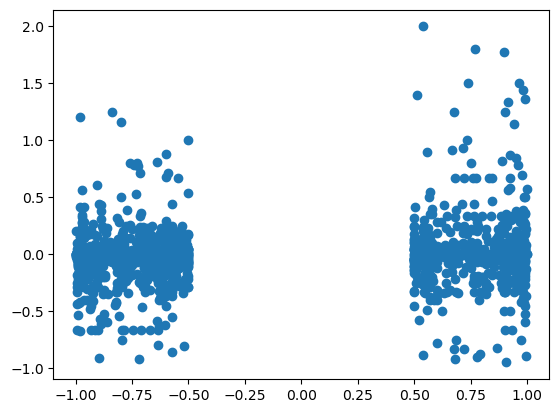

In [37]:
d0 = data_minute_lvl[(data_minute_lvl['obi_l1'] != -1) & (data_minute_lvl['obi_l1'] != 1)]
d1 = d0[(d0['obi_l1'] <= -0.5) | (d0['obi_l1'] >= 0.5)]
plt.scatter(d1['obi_l1'], d1['next_minute_return'])

In [39]:
data_minute_lvl['next_minute_return'].describecribe()

count    8270.00000
mean            inf
std             NaN
min        -0.95122
25%         0.00000
50%         0.00000
75%         0.00000
max             inf
Name: next_minute_return, dtype: float64

In [40]:
data['midprice'].describe()

count    982445.0
mean          inf
std           NaN
min           0.5
25%          21.0
50%          43.5
75%          60.0
max           inf
Name: midprice, dtype: float64

ValueError: supplied range of [-0.9512195121951219, inf] is not finite

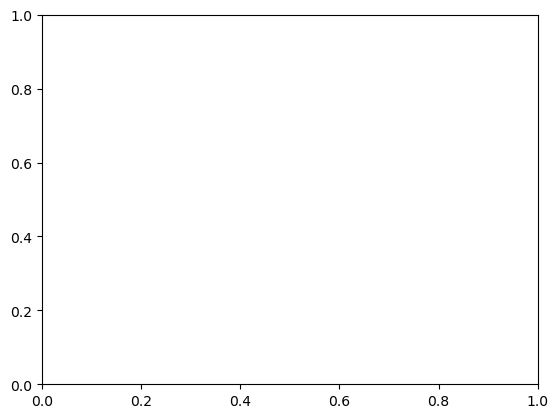

In [38]:
plt.hist(data_minute_lvl['next_minute_return'], density=True)

In [ ]:
'''
After specifying an interval in seconds, x, this code, for each ticker, finds the correlation betweeen L1, 2, and 3
orderbook imbalance values and the first delta related to the ticker's midprice return after >= x seconds pass.
The data is stored in a dataframe and described
'''

corr_dict = {'ticker': [], 'l1_corr': [], 'l2_corr': [], 'l3_corr': []}
for ticker in tickers:
    group = gpo.get_group(ticker)
    group = group.reset_index(drop=True)
    prev_ts = None
    prev_idx = None
    if group.shape[0] < 200:
        continue
        
    rtns = []
    l1_obis = []
    l2_obis = []
    l3_obis = []
    for idx, row in group.iterrows():
        if idx == 0:
            prev_ts = row['timestamp'].to_pydatetime()
            prev_idx = idx
        else:
            cur_ts = row['timestamp'].to_pydatetime()
            if (cur_ts - prev_ts).seconds > 120:
                cur_midprice = row['midprice']
                prev_midprice = group.iloc[prev_idx]['midprice']
                ret = (cur_midprice-prev_midprice)/prev_midprice
                prev_l1_obi = group.iloc[prev_idx]['obi_l1']
                prev_l2_obi = group.iloc[prev_idx]['obi_l2']
                prev_l3_obi = group.iloc[prev_idx]['obi_l3']
                
                rtns.append(ret)
                l1_obis.append(prev_l1_obi)
                l2_obis.append(prev_l2_obi)
                l3_obis.append(prev_l3_obi)
                
                prev_ts = cur_ts
                prev_idx = idx
    
    l1_corr = np.corrcoef(rtns, l1_obis)[0,1]
    l2_corr = np.corrcoef(rtns, l2_obis)[0,1]
    l3_corr = np.corrcoef(rtns, l3_obis)[0,1]
    corr_dict['ticker'].append(ticker)
    corr_dict['l1_corr'].append(l1_corr)
    corr_dict['l2_corr'].append(l2_corr)
    corr_dict['l3_corr'].append(l3_corr)


corr_df = pd.DataFrame(data=corr_dict)
corr_df.describe()
    


In [ ]:
'''
After specifying a lookahead period, this code, for each ticker, finds the correlation betweeen L1, 2, and 3
orderbook imbalance values and the midprice return after lookahead period delta messages related to the ticker.
The data is stored in a dataframe
'''

lookahead_period = 5
corr_dict = {'ticker': [], 'l1_corr': [], 'l2_corr': [], 'l3_corr': []}
for ticker in tickers:
    group = gpo.get_group(ticker)
    group = group.reset_index(drop=True)
    
    if group.shape[0] < 200:
        continue
    
    
    midprice = group['midprice'].tolist()
    obi_l1 = group['obi_l1'].tolist()[:len(midprice)-lookahead_period]
    obi_l2 = group['obi_l2'].tolist()[:len(midprice)-lookahead_period]
    obi_l3 = group['obi_l3'].tolist()[:len(midprice)-lookahead_period]
    midprice_return = (np.array(midprice[lookahead_period:])-np.array(midprice[:len(midprice)-lookahead_period]))/np.array(midprice[:len(midprice)-lookahead_period])
    
    l1_corr = np.corrcoef(obi_l1, midprice_return)[0,1]
    l2_corr = np.corrcoef(obi_l2, midprice_return)[0,1]
    l3_corr = np.corrcoef(obi_l3, midprice_return)[0,1]
    
    corr_dict['ticker'].append(ticker)
    corr_dict['l1_corr'].append(l1_corr)
    corr_dict['l2_corr'].append(l2_corr)
    corr_dict['l3_corr'].append(l3_corr)
    
corr_df = pd.DataFrame(data=corr_dict)
    


In [ ]:
corr_df.describe()

hard to claim that orderbook imbalance values are correlated with future midprice returns at all.. data points to independence

In [ ]:
'''
After specifying a lookahead period, this code, for each ticker, finds the correlation betweeen L1, 2, and 3
orderbook imbalance values that < -0.75 or > 0.75 and the midprice return after lookahead period delta messages related to the ticker.
The data is stored in a dataframe
'''

lookahead_period = 5
corr_dict = {'ticker': [], 'l1_corr': [], 'l2_corr': [], 'l3_corr': []}
for ticker in tickers:
    group = gpo.get_group(ticker)
    group = group.reset_index(drop=True)
    
    if group.shape[0] < 200:
        continue
    
    
    midprice = group['midprice'].tolist()
    obi_l1 = group['obi_l1'].tolist()[:len(midprice)-lookahead_period]
    obi_l2 = group['obi_l2'].tolist()[:len(midprice)-lookahead_period]
    obi_l3 = group['obi_l3'].tolist()[:len(midprice)-lookahead_period]
    midprice_return = (np.array(midprice[lookahead_period:])-np.array(midprice[:len(midprice)-lookahead_period]))/np.array(midprice[:len(midprice)-lookahead_period])
    
    l1_x = []
    l1_y = []
    l2_x = []
    l2_y = []
    l3_x = []
    l3_y = []
    
    for idx in range(len(obi_l1)):
        if abs(obi_l1[idx]) > 0.75:
            l1_x.append(obi_l1[idx])
            l1_y.append(midprice_return[idx])
    
    for idx in range(len(obi_l2)):
        if abs(obi_l2[idx]) > 0.75:
            l2_x.append(obi_l2[idx])
            l2_y.append(midprice_return[idx])
    
    for idx in range(len(obi_l3)):
        if abs(obi_l3[idx]) > 0.75:
            l3_x.append(obi_l3[idx])
            l3_y.append(midprice_return[idx])
    
    l1_corr = np.corrcoef(l1_x, l1_y)[0,1]
    l2_corr = np.corrcoef(l2_x, l2_y)[0,1]
    l3_corr = np.corrcoef(l3_x, l3_y)[0,1]
    
    corr_dict['ticker'].append(ticker)
    corr_dict['l1_corr'].append(l1_corr)
    corr_dict['l2_corr'].append(l2_corr)
    corr_dict['l3_corr'].append(l3_corr)
    
corr_df = pd.DataFrame(data=corr_dict)
    


In [ ]:
corr_df.describe()

Evidence pointing towards independence of future midprice returns given past orderbook imbalance values

In [ ]:
'''
orderbook flow imbalance

requires a start point and end point that defines an interval

let bb_1 = best bid at start, ba_1 = best ask at start, bbv_1 = best bid volume at start, bav_1 = best ask volume at start
bb_2, ba_2, bbv_2, and bav_2 are defined equivalently except they refer to the end of the interval

if bb_1 > bb_2
    best bid decreases and delta_bid = -bbv_1
elif bb_1 == bb_2
    best bid remains the same and delta_bid = bbv_2 - bbv_1
else
    best bid increases and delta_bid = bbv_2

if ba_1 > ba_2
    best ask decreases and delta_ask = -bav_2
elif ba_1 == ba_2
    best ask stays the same and delta_ask = -(bav_2 - bav_1)
else
    best ask increases and delta_ask = bav_1
    
delta_bid, delta_ask > 0 => positive price pressure <=> bid increases and/or ask increases and/or 
volume at bb increases and/or volume at ba decreases 

delta_bid, delta_ask < 0 => negative price pressure <=> bid decreases and/or ask decreases and/or
volume at best bid decreases and/or volume at best ask increases 

flow imbalance = delta_bid + delta_ask 
flow imbalance < 0 => negative price pressure
flow imbalance > 0 => positive price pressure


as is, flow imbalance, delta_bid, and delta_ask don't take into account the magnitude of a price movement

can modify definitions to take magnitude of price movement into account as follows:

if bb_1 > bb_2
    best bid decreases and delta_bid = -bbv_1 * (bb_1 - bb_2)
elif bb_1 == bb_2
    best bid remains the same and delta_bid = bbv_2 - bbv_1
else
    best bid increases and delta_bid = bbv_2 * (bb_2 - bb_1)

if ba_1 > ba_2
    best ask decreases and delta_ask = -bav_2 * (ba_1 - ba_2)
elif ba_1 == ba_2
    best ask stays the same and delta_ask = -(bav_2 - bav_1)
else
    best ask increases and delta_ask = bav_1 * (ba_2 - ba_1)


goal: define some interval length. for each interval, calculate flow imbalance. Determine if
flow imbalance can be used to predict future price movement

algorithm:
for each day
    for each ticker
        initialize 2 empty lists for bids and asks which together will give one a state of the order book
         for each minute, m, starting from earliest minute there is data for and through 4 pm ET, collect orderbook change msgs
         that occur from [m, m+1)   
            case 1: no orderbook changes during the minute so flow_imbalance, f, is 0 for the minute STARTING at m
            case 2: there are orderbook changes, calculate flow_imbalance f for the minute STARTING at m
            
            note: keep track of best bid, best ask at start of each minute m. To calculate flow imbalance during minute m, we
            need to know starting bb, bbv, ba, bav as well as these ending qtys

flow imbalance is highly correlated with midprice return so it might be simpler to just examine how well
midprice return is a predictor of the next minute's midprice return 


'''




data_dict = {'ticker': [], 'flow_imbalance': [], 'midprice_return': [], 'timestamp': []}
date_ = date(2024, 1, 2)
#loop thru each day
while date_ <= date.today():
    
    cursor.execute('select distinct(market_ticker) from ob_snapshot where processed_ts like \'%{}%\''.format(date_.isoformat()))
    ticker_rows = cursor.fetchall()
    tickers = []
    #gets all of the current day's tickers
    for row in ticker_rows:
        tickers.append(row[0])
    
    #loop thru each ticker
    for ticker in tickers:
        
        #find number of commands
        cursor.execute('select count(distinct(command_id)) from ob_snapshot where processed_ts like \'%{}%\' and market_ticker = \'{}\''.format(date_.isoformat(), ticker))
        rows = cursor.fetchall()
        num_cmd_ids = None

        if rows is not None and len(rows) > 0:
            num_cmd_ids = rows[0][0]
        if num_cmd_ids is None:
            continue
        
        #loop thru each. command id
        for cmd_id in range(1,num_cmd_ids+1):
            #get starting snapshot of the orderbook for this ticker
            cursor.execute('select * from ob_snapshot where command_id = {} and processed_ts like \'%{}%\' and market_ticker = \'{}\' order by processed_ts asc'.format(cmd_id, date_.isoformat(), ticker))
            snapshot_rows = cursor.fetchall()
            
            if len(snapshot_rows) != 1:
                continue
            row = snapshot_rows[0]
    
            t = row[2]
            try:
                bids_dict = ast.literal_eval(row[3])
                asks_dict = ast.literal_eval(row[4])
            except:
                continue
            bids_list = []
            asks_list = []
            for p, q in bids_dict.items():
                bids_list.append([p, q])
            for p, q in asks_dict.items():
                asks_list.append([p, q])

            bids_list.sort(key = lambda x:x[0])
            asks_list.sort(key = lambda x:x[0])
            
            
            prev_bb = get_best_bid(bids_list)
            prev_ba = get_best_ask(asks_list)
            prev_mp = (prev_bb + prev_ba)/2
            prev_bbv = get_bbv(bids_list)
            prev_bav = get_bav(asks_list)
            prev_ts = datetime.strptime(row[5], '%Y-%m-%dT%H:%M:%S.%fZ')
            prev_hour = prev_ts.hour
            prev_minute = prev_ts.minute

            cursor.execute('select * from ob_delta where command_id = {} and processed_ts like \'%{}%\' and market_ticker = \'{}\' order by processed_ts asc'.format(cmd_id, date_.isoformat(), ticker))
            delta_rows = cursor.fetchall()
            
            
            for row in delta_rows:
                t = row[2]
                price = row[3]
                delta = row[4]
                side = row[5]
                ts = datetime.strptime(row[6], '%Y-%m-%dT%H:%M:%S.%fZ')
                hour = ts.hour
                minute = ts.minute
                second = ts.second
                if (hour == prev_hour and minute == prev_minute) or (second == 0 and hour == prev_hour and minute - 1 == prev_minute) or (second == 0 and prev_minute == 59 and minute == 0 and hour - 1 == prev_hour):
                    if side == 'yes':
                        #bid
                        update_bids(bids_list, price, delta)
                    else:
                        #ask
                        update_asks(asks_list, price, delta)
                else:
                    #current delta is not in the same minute
                    cur_bb = get_best_bid(bids_list)
                    cur_bbv = get_bbv(bids_list)
                    cur_ba = get_best_ask(asks_list)
                    cur_bav = get_bav(asks_list)
                    cur_mp = (cur_bb + cur_ba)/2
                    orig_delta_bid = None
                    orig_delta_ask = None
                    
                    if cur_bb > prev_bb:
                        orig_delta_bid = cur_bbv * (cur_bb - prev_bb)
                    elif cur_bb < prev_bb:
                        orig_delta_bid = -prev_bbv * abs(cur_bb-prev_bb)
                    else:
                        orig_delta_bid = cur_bbv - prev_bbv
                    
                    if cur_ba < prev_ba:
                        orig_delta_ask = -cur_bav * abs(cur_ba - prev_ba)
                    elif cur_ba > prev_ba:
                        orig_delta_ask = prev_bav * (cur_ba - prev_ba)
                    else:
                        orig_delta_ask = prev_bav - cur_bav
                    
                    flow_imb = orig_delta_bid + orig_delta_ask
                    midprice_rtn = (cur_mp-prev_mp)/prev_mp
                    cur_dt = datetime(year=ts.year, month = ts.month, day = ts.day, hour = prev_hour, minute = prev_minute)
                    data_dict['ticker'].append(ticker)
                    data_dict['flow_imbalance'].append(flow_imb)
                    data_dict['midprice_return'].append(midprice_rtn)
                    data_dict['timestamp'].append(cur_dt)
                    

                    prev_bb = cur_bb
                    prev_bbv = cur_bbv
                    prev_ba = cur_ba
                    prev_bav = cur_bav
                    prev_mp = cur_mp
                    prev_hour = hour
                    prev_minute = minute
                    
                    if side == 'yes':
                        #bid
                        update_bids(bids_list, price, delta)
                    else:
                        #ask
                        update_asks(asks_list, price, delta)
                    
    print(date_.isoformat())
    date_+=timedelta(days=1)      
            

data = pd.DataFrame(data_dict)

In [ ]:
nonzero_flow = data[data['flow_imbalance']!= 0]

In [ ]:
nonzero_flow

In [ ]:
x = nonzero_flow['flow_imbalance'].tolist()
y = nonzero_flow['midprice_return'].tolist()
plt.scatter(x,y)

In [ ]:
bounded_flow = nonzero_flow[(nonzero_flow['flow_imbalance'] >= -2500) & (nonzero_flow['flow_imbalance'] <= 2500)]
x = bounded_flow['flow_imbalance'].tolist()
y = bounded_flow['midprice_return'].tolist()
plt.scatter(x,y)

These plots are plotting flow imbalance over a certain minute against the midprice return over the same minute. As is expected, there is high correlation

will examine how predictive flow imbalance is if at all next

In [ ]:
gpo = data.groupby('ticker')
tickers = list(set(data['ticker'].tolist()))
data_dict = {'ticker': [], 'flow_imbalance': [], 'next_min_midprice_return': []}
for ticker in tickers:
    group = gpo.get_group(ticker)
    group = group.reset_index(drop=True)
    for idx in range(group.shape[0]-1):
        cur_row = group.iloc[idx]
        next_row = group.iloc[idx+1]
        if cur_row['timestamp'].to_pydatetime() + timedelta(minutes=1) == next_row['timestamp'].to_pydatetime():
            data_dict['ticker'].append(cur_row['ticker'])
            data_dict['flow_imbalance'].append(cur_row['flow_imbalance'])
            data_dict['next_min_midprice_return'].append((next_row['midprice_return']))

flow_return_df = pd.DataFrame(data=data_dict)

In [ ]:
flow_return_df

In [ ]:
bounded_flow_return_df = flow_return_df[(flow_return_df['flow_imbalance']>=-1000) & (flow_return_df['flow_imbalance'] <= 1000)]

In [ ]:
x = bounded_flow_return_df['flow_imbalance'].tolist()
y = bounded_flow_return_df['next_min_midprice_return'].tolist()
plt.scatter(x,y)

In [ ]:
x = flow_return_df['flow_imbalance'].tolist()
y = flow_return_df['next_min_midprice_return'].tolist()
plt.scatter(x,y)

Seems like next minute midprice return and current minute's orderbook flow imbalance are more or less independent